In [239]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [240]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Detector e Descritor

- computei o detector e descritor de um batch para criar massa de dados para a rede siamesa

In [241]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points,extract_features_with_box
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
from training import KeyEqGroup, KeyPointsSelection
torch.__version__


def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 15
    args.margin_loss = 2.0
    args.border  = 15
    args.nms_size = 10 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args


args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)




MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

Já foi treinado
epoca 100 loss 3.5150668924930053
15 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Segementa todas as features de batch só

pos predict  torch.Size([15, 1, 180, 180]) torch.Size([15, 1, 180, 180])
torch.Size([1237, 31, 31]) torch.Size([1237, 31, 31]) torch.Size([1237, 2, 31, 31])


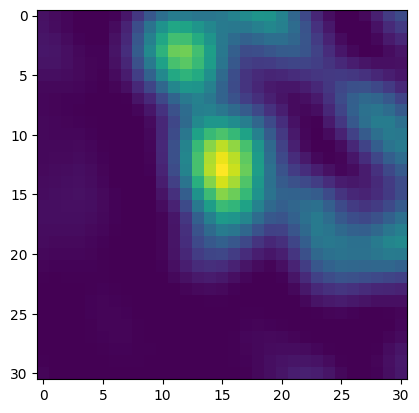

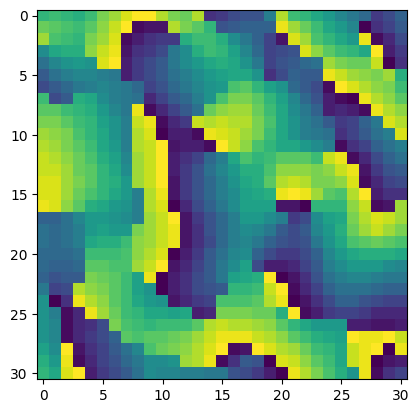

In [242]:
feature,orien1 = predict_single_points(single_point_model,batch)
batch_result,coords = extract_features_with_box(feature,orien1)

# concatena em um tensor somente as features e orientações
for i,(boxs,mini_feat_batch,mini_orien_batch) in enumerate(batch_result):
    if i==0:
        mini_feat_batch_concat = mini_feat_batch
        mini_orien_batch_concat = mini_orien_batch
    else:
        mini_feat_batch_concat = torch.cat([mini_feat_batch_concat,mini_feat_batch], dim=0)
        mini_orien_batch_concat = torch.cat([mini_orien_batch_concat,mini_orien_batch], dim=0)
    # print('batch ',i,mini_orien_batch_concat.shape)

mini_dataloader = torch.stack([mini_feat_batch_concat,mini_orien_batch_concat], dim=1)
print(mini_feat_batch_concat.shape,mini_orien_batch_concat.shape,mini_dataloader.shape)

plt.imshow(mini_dataloader[0,0,:,:].cpu().detach())
plt.show()
plt.imshow(mini_dataloader[0,1,:,:].cpu().detach())
plt.show()

#### Dividi o array em batch de train e test de tamanho 10

In [243]:
import torch
from torch.utils.data import DataLoader, random_split

# Definindo o tamanho do lote desejado
batch_size = 10

# Dividindo o tensor em conjuntos de treinamento e teste
train_ratio = 0.8
train_size = int(train_ratio * len(mini_dataloader))
test_size = len(mini_dataloader) - train_size

train_tensor, test_tensor = random_split(mini_dataloader, [train_size, test_size])

# Criando os dataloaders para treinamento e teste
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

# Verificando o tamanho dos conjuntos de treinamento e teste (em número de lotes)
print(len(train_loader))  # Saída: 64 (80% de 800 dividido por 10)
print(len(test_loader))  # Saída: 16 (20% de 800 dividido por 10)


99
25


### Define arquitetura do modelo de rede siamesa

In [244]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(
                enn.MaskModule(feat_type_in, n_dim, margin=2),
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=1, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=2, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        # self.pool2 = enn.PointwiseAvgPool(feat_type_out, 21)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)        
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        self.dense1 = nn.Linear(2*1*25*25, 256)
        self.dense2 = nn.Linear(256, 64)
        self.dense3 = nn.Linear(64, 1)
        #função de ativação ideal para retornar um valor entre 0 e 1
        self.activation = nn.Sigmoid()

    
    def forward(self,X1,X2)->torch.Tensor:
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
      
        x = torch.cat((flatten_x1,flatten_x2),dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.activation(x)
        return x


class Siamesa(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_dim=n_dim,n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x
    

X1=torch.ones(8,2,31,31).to(device)

model =Siamesa(n_dim=31,n_channel=2).to(device)
temp = model(X1,X1)

temp.shape


torch.Size([8, 1])

### Metodos para o processo de treinamento

In [245]:
from tqdm import tqdm

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = 0.4
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    # print(loss)
    loss = torch.sum(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=0,translate=(0.1,0.1),scale=(0.9,1.1))(x)
    return x


In [246]:
model =Siamesa(n_dim=31,n_channel=2).to(device)
model(X1,X1)

tensor([[0.4825],
        [0.4825],
        [0.4825],
        [0.4825],
        [0.4825],
        [0.4825],
        [0.4825],
        [0.4825]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [247]:
from torch.optim.lr_scheduler import ExponentialLR
def train(model,train_loader,test_loader,loss_fn,epochs=10,device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.000001)
    # scheduler = ExponentialLR(optimizer, gamma=0.75)
    for epoch in range(epochs):
        loss_train = train_one_epoch(model,train_loader,optimizer,loss_fn,device)
        loss_test = test(model,test_loader,loss_fn,device)
        print()
        # if (epoch % 5 == 0) and (epoch != 0):
        #     scheduler.step()
        # print('initial_lr ',optimizer.param_groups[0]['initial_lr'],'lr ', optimizer.param_groups[0]['lr'])
        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')
        

train(model,train_loader,test_loader,loss_fn,epochs=25,device=device)

Tests : 100%|██████████| 25/25 [00:00<00:00, 87.23it/s]



Epoch: 0, Train Loss: 0.3999, Test Loss: 0.3999


Tests : 100%|██████████| 25/25 [00:00<00:00, 70.81it/s]



Epoch: 1, Train Loss: 0.3998, Test Loss: 0.3998


Tests : 100%|██████████| 25/25 [00:00<00:00, 88.19it/s]



Epoch: 2, Train Loss: 0.3997, Test Loss: 0.3997


Tests : 100%|██████████| 25/25 [00:00<00:00, 89.02it/s]



Epoch: 3, Train Loss: 0.3997, Test Loss: 0.3997


Tests : 100%|██████████| 25/25 [00:00<00:00, 80.60it/s]



Epoch: 4, Train Loss: 0.3996, Test Loss: 0.3996


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.93it/s]



Epoch: 5, Train Loss: 0.3994, Test Loss: 0.3992


Tests : 100%|██████████| 25/25 [00:00<00:00, 87.91it/s]



Epoch: 6, Train Loss: 0.3993, Test Loss: 0.3993


Tests : 100%|██████████| 25/25 [00:00<00:00, 89.81it/s]



Epoch: 7, Train Loss: 0.3990, Test Loss: 0.3990


Tests : 100%|██████████| 25/25 [00:00<00:00, 87.61it/s]



Epoch: 8, Train Loss: 0.3989, Test Loss: 0.3986


Tests : 100%|██████████| 25/25 [00:00<00:00, 70.44it/s]



Epoch: 9, Train Loss: 0.3984, Test Loss: 0.3985


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.91it/s]



Epoch: 10, Train Loss: 0.3982, Test Loss: 0.3979


Tests : 100%|██████████| 25/25 [00:00<00:00, 89.53it/s]



Epoch: 11, Train Loss: 0.3976, Test Loss: 0.3973


Tests : 100%|██████████| 25/25 [00:00<00:00, 89.70it/s]



Epoch: 12, Train Loss: 0.3971, Test Loss: 0.3968


Tests : 100%|██████████| 25/25 [00:00<00:00, 69.11it/s]



Epoch: 13, Train Loss: 0.3968, Test Loss: 0.3965


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.83it/s]



Epoch: 14, Train Loss: 0.3962, Test Loss: 0.3954


Tests : 100%|██████████| 25/25 [00:00<00:00, 89.96it/s]



Epoch: 15, Train Loss: 0.3957, Test Loss: 0.3945


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.87it/s]



Epoch: 16, Train Loss: 0.3955, Test Loss: 0.3936


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.81it/s]



Epoch: 17, Train Loss: 0.3941, Test Loss: 0.3937


Tests : 100%|██████████| 25/25 [00:00<00:00, 88.76it/s]



Epoch: 18, Train Loss: 0.3933, Test Loss: 0.3899


Tests : 100%|██████████| 25/25 [00:00<00:00, 89.89it/s]



Epoch: 19, Train Loss: 0.3931, Test Loss: 0.3908


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.94it/s]



Epoch: 20, Train Loss: 0.3913, Test Loss: 0.3897


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.79it/s]



Epoch: 21, Train Loss: 0.3904, Test Loss: 0.3895


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.16it/s]



Epoch: 22, Train Loss: 0.3901, Test Loss: 0.3868


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.06it/s]



Epoch: 23, Train Loss: 0.3875, Test Loss: 0.3836


Tests : 100%|██████████| 25/25 [00:00<00:00, 87.75it/s]


Epoch: 24, Train Loss: 0.3864, Test Loss: 0.3842


### Teste com a rede siamesa

In [248]:
import matplotlib.pyplot as plt
#criar funcao para exibir 3 imagens lado a lado
def show_images(image1, image2, image3, title1="Image 1", title2="Image 2", title3="Image 3"):
    vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image1.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[1].imshow(image2.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[2].imshow(image3.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[2].set_title(title3)
    plt.show()

In [249]:
#normalizar tensor
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

#criar uma funcao para rotacionar duas imagens com kornia
import kornia
def rotate_images(image1, image2, angle):
    image1 = kornia.geometry.transform.rotate(image1, angle)
    image2 = kornia.geometry.transform.rotate(image2, angle)
    return image1, image2


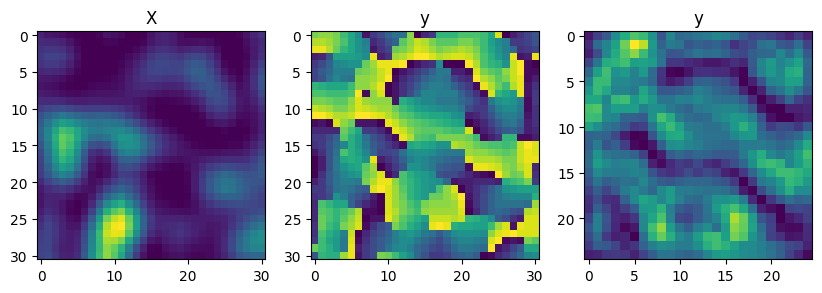

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.6951, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.6180, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3480, device='cuda:0') tensor([0.1758], device='cuda:0')


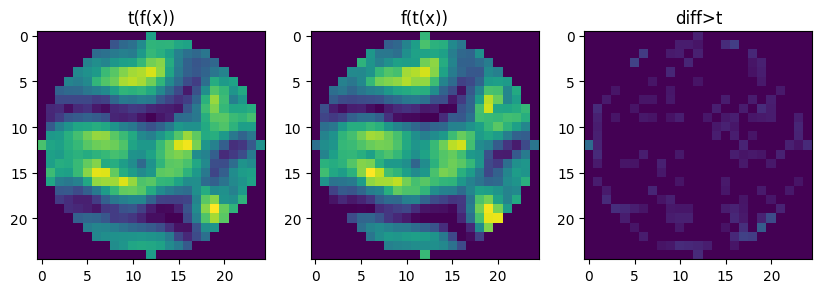

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.7470, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.7217, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1616, device='cuda:0') tensor([0.1794], device='cuda:0')


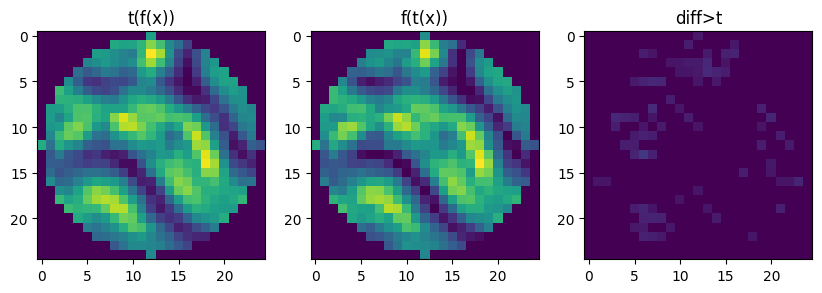

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.9551, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.7793, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3254, device='cuda:0') tensor([0.1412], device='cuda:0')


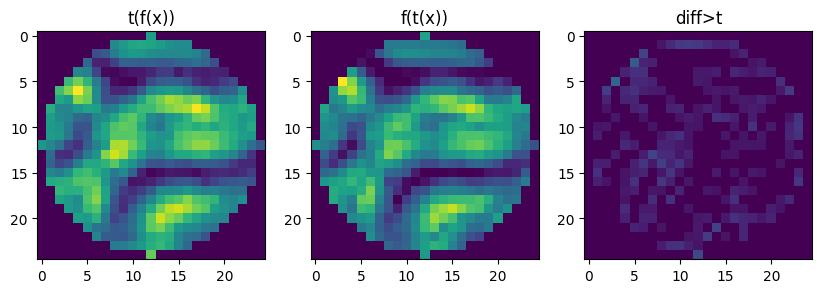

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.5720, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.6271, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1573, device='cuda:0') tensor([0.1821], device='cuda:0')


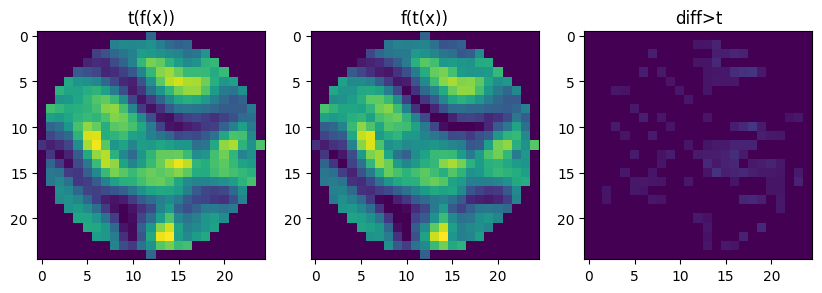

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.6379, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.6005, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3105, device='cuda:0') tensor([0.1790], device='cuda:0')


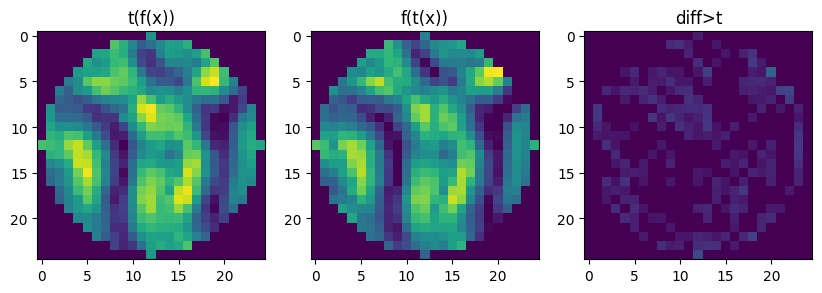

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.7470, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.7217, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1616, device='cuda:0') tensor([0.1961], device='cuda:0')


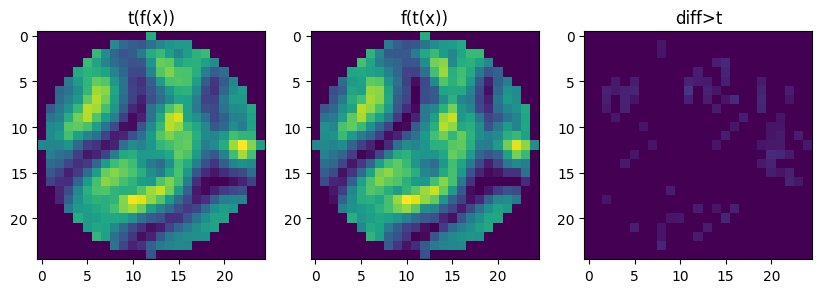

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.8036, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.8817, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2578, device='cuda:0') tensor([0.2137], device='cuda:0')


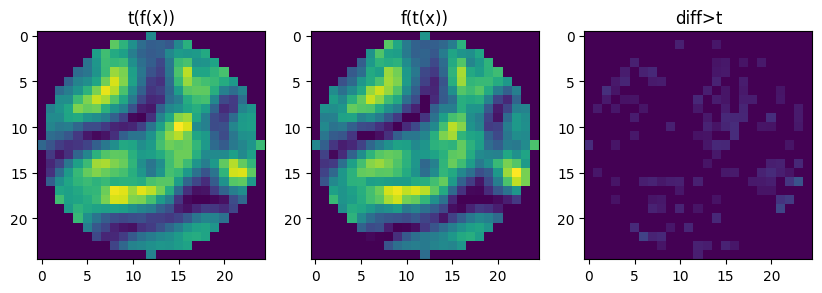

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.9399, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.8874, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2170, device='cuda:0') tensor([0.2048], device='cuda:0')


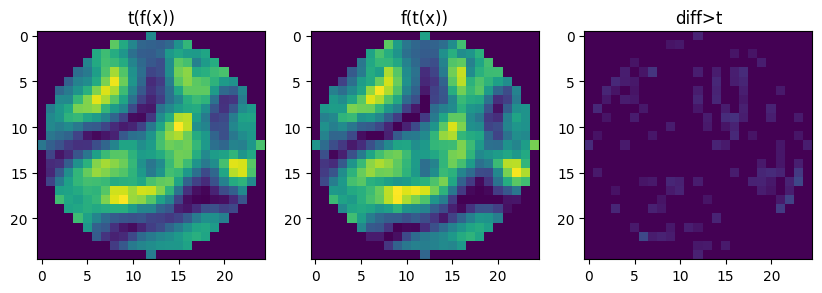

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.8256, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.5463, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3375, device='cuda:0') tensor([0.1400], device='cuda:0')


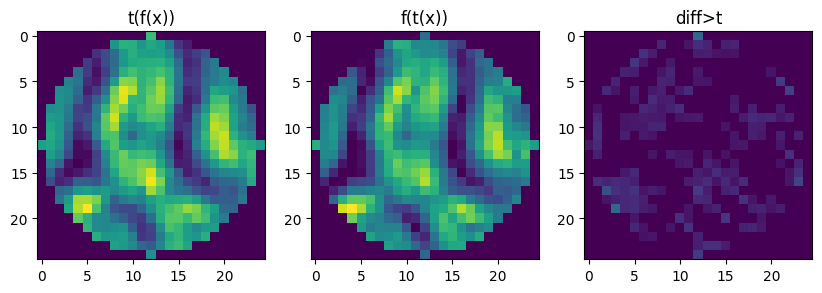

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.9359, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.8585, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1451, device='cuda:0') tensor([0.1834], device='cuda:0')


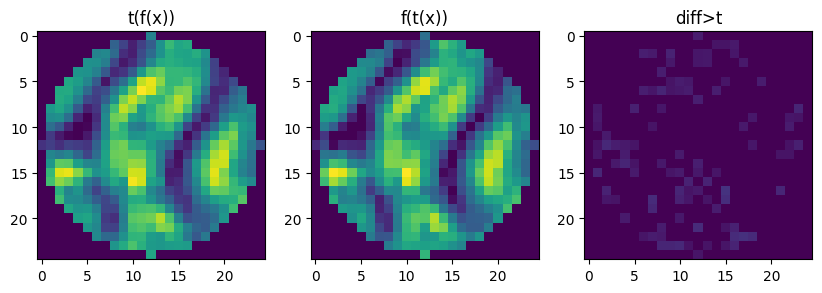

In [267]:
model_feature = model.feature
model_discriminator = model.discriminator

torch.manual_seed(42)
angles =  torch.tensor(np.random.uniform(low=0.0, high=360.0, size=10)//1, dtype=torch.float32).to(device)

c_mask = create_circular_mask(y.shape[2],y.shape[3])
c_mask = torch.tensor(c_mask).to(device)

iterator=iter(test_loader)
data = next(iterator)
index = 5 
with torch.no_grad():
    y = model_feature(data)
    show_images(normalize_tensor(data[index,0]),normalize_tensor(data[index,1]),normalize_tensor(y[index,0]),title1="X",title2="y",title3="y")
    for angle in angles:
        data_rotated, y_rotated = rotate_images(data, y, angle)
        y_rotated2 = model_feature(data_rotated)
        
        distance =model_discriminator(y_rotated,y_rotated2)
        y_rotated2 = y_rotated2*c_mask
        y_rotated = y_rotated*c_mask

        y1n=normalize_tensor(y_rotated[0,0])
        y2n=normalize_tensor(y_rotated2[0,0])

        print(y1n.min(),y_rotated.min(),y1n.max(),y_rotated.max())
        print(y2n.min(),y_rotated2.min(),y2n.max(),y_rotated2.max())
        
        diff = abs(y2n - y1n)
        t = 0.05
        diff[abs(diff) < t] = 0

        print(diff.min(),diff.max(),distance[0])
        show_images(y1n,y2n,diff,title1="t(f(x))",title2="f(t(x))",title3="diff>t")

In [269]:
def copy_tensor(tensor,times):
    tensor = tensor.repeat(times,1,1,1)
    return tensor

size = len(data)

with torch.no_grad():
  for i in range(size):
    img_temp = data[i][None]
    data_temp = copy_tensor(img_temp,size)

    # print(img_temp.shape,data_temp.shape)
    distances = model(data_temp,data)
    print("index: ",i," found in ",distances.argmin().item()," position ")

index:  0  found in  3  position 
index:  1  found in  3  position 
index:  2  found in  3  position 
index:  3  found in  3  position 
index:  4  found in  3  position 
index:  5  found in  3  position 
index:  6  found in  3  position 
index:  7  found in  3  position 
index:  8  found in  3  position 
index:  9  found in  3  position 


In [256]:
c_mask = create_circular_mask(data.shape[2],data.shape[3])
c_mask = torch.tensor(c_mask).to(device)

dist = model(data*c_mask,data*c_mask)
print(dist.argmin().item(),dist)

t = torch.ones(10,2,31,31).to(device)
dist = model(data,t*c_mask)
print(dist.argmin().item(),dist)

6 tensor([[0.1761],
        [0.2133],
        [0.1842],
        [0.1859],
        [0.2044],
        [0.1653],
        [0.1579],
        [0.2105],
        [0.1961],
        [0.1694]], device='cuda:0', grad_fn=<SigmoidBackward0>)
8 tensor([[0.7196],
        [0.7880],
        [0.5219],
        [0.5908],
        [0.7451],
        [0.6662],
        [0.5045],
        [0.4285],
        [0.3745],
        [0.5853]], device='cuda:0', grad_fn=<SigmoidBackward0>)
